# Data analysis 2

## Adding some feature engineering

In [1]:
#Setting up environment
import pandas as pd
import os
import numpy as np
from IPython.display import Math

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import metrics, svm,tree,preprocessing
from pprint import pprint
from sklearn.metrics import (auc, confusion_matrix, roc_curve, accuracy_score, precision_score)
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#Uploading data
df_processed= pd.read_csv("/Suzi fun files/QB course/QB_DS_FinalProject/data/processed/data_all_features.csv", index_col=[0])
df_processed.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_category
id,,,,,,,,,,,,,,,,,,,,,
842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


## Correlation matrix in Data exploration has shown that there is a lot of multilinearity in the data set. 
## Calculating the variance inflation factor 
https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python

In [3]:
def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, 
                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
         for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs

variance_inflation_factors(df_processed)

const                      1945.673866
radius_mean                3817.259795
texture_mean                 11.891280
perimeter_mean             3792.697001
area_mean                   348.115385
smoothness_mean               8.194309
compactness_mean             51.445960
concavity_mean               71.002747
concave points_mean          60.172431
symmetry_mean                 4.220806
fractal_dimension_mean       15.756978
radius_se                    75.737325
texture_se                    4.205686
perimeter_se                 70.398925
area_se                      41.196467
smoothness_se                 4.070801
compactness_se               15.366350
concavity_se                 15.914022
concave points_se            11.601253
symmetry_se                   5.179151
fractal_dimension_se          9.724753
radius_worst                815.945630
texture_worst                18.606605
perimeter_worst             405.150023
area_worst                  343.494355
smoothness_worst         

### radius_mean has very high VIF, so does perimeter_mean
### Looking at sorted correlation pairs 

In [4]:
c = df_processed.corr().abs()
s = c.unstack()
sorted_correlation = s.sort_values(kind="quicksort")
sorted_correlation[900:-31]

area_se          radius_se          0.951830
radius_se        area_se            0.951830
perimeter_worst  area_mean          0.959120
area_mean        perimeter_worst    0.959120
                 area_worst         0.959213
area_worst       area_mean          0.959213
area_mean        radius_worst       0.962746
radius_worst     area_mean          0.962746
perimeter_worst  radius_mean        0.965137
radius_mean      perimeter_worst    0.965137
perimeter_mean   radius_worst       0.969476
radius_worst     perimeter_mean     0.969476
radius_mean      radius_worst       0.969539
radius_worst     radius_mean        0.969539
perimeter_worst  perimeter_mean     0.970387
perimeter_mean   perimeter_worst    0.970387
radius_se        perimeter_se       0.972794
perimeter_se     radius_se          0.972794
perimeter_worst  area_worst         0.977578
area_worst       perimeter_worst    0.977578
radius_worst     area_worst         0.984015
area_worst       radius_worst       0.984015
area_mean 

### Removing features with high correlation. (Done in several steps while simultaneously looking at the VIF changes and the correlation of the leftover features in the next step).

In [5]:
df_removing_features = df_processed.drop(['radius_mean','area_mean','perimeter_worst','area_worst',
                                          'perimeter_se','concavity_mean','compactness_mean','perimeter_mean',
                                          'area_se','texture_mean','concave points_mean','concavity_worst','compactness_worst',
                                         'concave points_worst','fractal_dimension_mean',
                                          'smoothness_worst','fractal_dimension_worst','radius_se','compactness_se','concave points_se'],axis = 1)
variance_inflation_factors(df_removing_features)

const                   130.991324
smoothness_mean           1.845235
symmetry_mean             2.962952
texture_se                2.835756
smoothness_se             1.935435
concavity_se              2.411655
symmetry_se               2.655117
fractal_dimension_se      2.588768
radius_worst              2.986870
texture_worst             2.519286
symmetry_worst            4.119275
diagnosis_category        3.442057
Name: VIF, dtype: float64

In [6]:
c = df_removing_features.corr().abs()
s = c.unstack()
sorted_correlation = s.sort_values(kind="quicksort")
sorted_correlation[100:-14]

texture_worst         diagnosis_category    0.456903
diagnosis_category    texture_worst         0.456903
smoothness_mean       symmetry_mean         0.557775
symmetry_mean         smoothness_mean       0.557775
symmetry_worst        symmetry_mean         0.699826
symmetry_mean         symmetry_worst        0.699826
fractal_dimension_se  concavity_se          0.727372
dtype: float64

In [7]:
df_removing_features.head()

,smoothness_mean,symmetry_mean,texture_se,smoothness_se,concavity_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,symmetry_worst,diagnosis_category
id,,,,,,,,,,,
842302,0.11840,0.2419,0.9053,0.006399,0.05373,0.03003,0.006193,25.38,17.33,0.4601,1
842517,0.08474,0.1812,0.7339,0.005225,0.01860,0.01389,0.003532,24.99,23.41,0.2750,1
84300903,0.10960,0.2069,0.7869,0.006150,0.03832,0.02250,0.004571,23.57,25.53,0.3613,1
84348301,0.14250,0.2597,1.1560,0.009110,0.05661,0.05963,0.009208,14.91,26.50,0.6638,1
84358402,0.10030,0.1809,0.7813,0.011490,0.05688,0.01756,0.005115,22.54,16.67,0.2364,1


In [8]:
df_removing_features.to_csv("/Suzi fun files/QB course/QB_DS_FinalProject/data/processed/data_cleaned_features.csv")

## Run a simple decision tree on my new data set
### Load my train and test data first

In [9]:
X_test_df= pd.read_csv("/Suzi fun files/QB course/QB_DS_FinalProject/data/interim/X_test.csv", index_col=[0])
X_test_df.columns=df_processed.columns[:-1]
X_test_df.head()
X_test = X_test_df.drop(['radius_mean','area_mean','perimeter_worst','area_worst',
                                          'perimeter_se','concavity_mean','compactness_mean','perimeter_mean',
                                          'area_se','texture_mean','concave points_mean','concavity_worst','compactness_worst',
                                         'concave points_worst','fractal_dimension_mean',
                                          'smoothness_worst','fractal_dimension_worst','radius_se','compactness_se','concave points_se'],axis = 1).values

In [10]:
X_train_df= pd.read_csv("/Suzi fun files/QB course/QB_DS_FinalProject/data/interim/X_train.csv", index_col=[0])
X_train_df.columns=df_processed.columns[:-1]
X_train = X_train_df.drop(['radius_mean','area_mean','perimeter_worst','area_worst',
                                          'perimeter_se','concavity_mean','compactness_mean','perimeter_mean',
                                          'area_se','texture_mean','concave points_mean','concavity_worst','compactness_worst',
                                         'concave points_worst','fractal_dimension_mean',
                                          'smoothness_worst','fractal_dimension_worst','radius_se','compactness_se','concave points_se'],axis = 1).values

In [11]:
y_train_df = pd.read_csv('/Suzi fun files/QB course/QB_DS_FinalProject/data/interim/y_train.csv', header=None, index_col=[0]);
y_train = y_train_df.iloc[:,0]
y_test_df = pd.read_csv('/Suzi fun files/QB course/QB_DS_FinalProject/data/interim/y_test.csv', header=None, index_col=[0]);
y_test = y_test_df.iloc[:,0]

In [12]:
# Tune Decision Tree
num_leaves = [5, 10, 15, 20, 30, 40, 50]
depth = np.arange(3, 21)
num_samples_split = np.arange(10,20)
params_DT = {"max_depth": depth, "min_samples_leaf": num_leaves, "min_samples_split":num_samples_split}
random_state = 42
classifier_DT = DecisionTreeClassifier(random_state=random_state)
grid_DT = GridSearchCV(classifier_DT, params_DT,scoring='roc_auc');
grid_DT.fit(X_train,y_train)

prediction_DT = grid_DT.predict(X_test)
probability_DT = grid_DT.predict_proba(X_test)

In [13]:
print("Accuracy:",metrics.accuracy_score(y_test, prediction_DT))

Accuracy: 0.9210526315789473


[Text(686.7692307692307, 498.3, 'concave points_mean <= 16.795\nsamples = 100.0%\nvalue = [0.629, 0.371]'),
 Text(515.0769230769231, 407.70000000000005, 'fractal_dimension_mean <= 0.357\nsamples = 66.4%\nvalue = [0.911, 0.089]'),
 Text(429.23076923076917, 317.1, 'concave points_mean <= 15.175\nsamples = 62.6%\nvalue = [0.951, 0.049]'),
 Text(171.69230769230768, 226.5, 'fractal_dimension_mean <= 0.198\nsamples = 51.9%\nvalue = [0.983, 0.017]'),
 Text(85.84615384615384, 135.89999999999998, 'samples = 2.4%\nvalue = [0.818, 0.182]'),
 Text(257.53846153846155, 135.89999999999998, 'symmetry_mean <= 33.35\nsamples = 49.5%\nvalue = [0.991, 0.009]'),
 Text(171.69230769230768, 45.299999999999955, 'samples = 45.9%\nvalue = [1.0, 0.0]'),
 Text(343.38461538461536, 45.299999999999955, 'samples = 3.5%\nvalue = [0.875, 0.125]'),
 Text(686.7692307692307, 226.5, 'area_mean <= 0.007\nsamples = 10.8%\nvalue = [0.796, 0.204]'),
 Text(600.9230769230769, 135.89999999999998, 'symmetry_mean <= 26.84\nsamples =

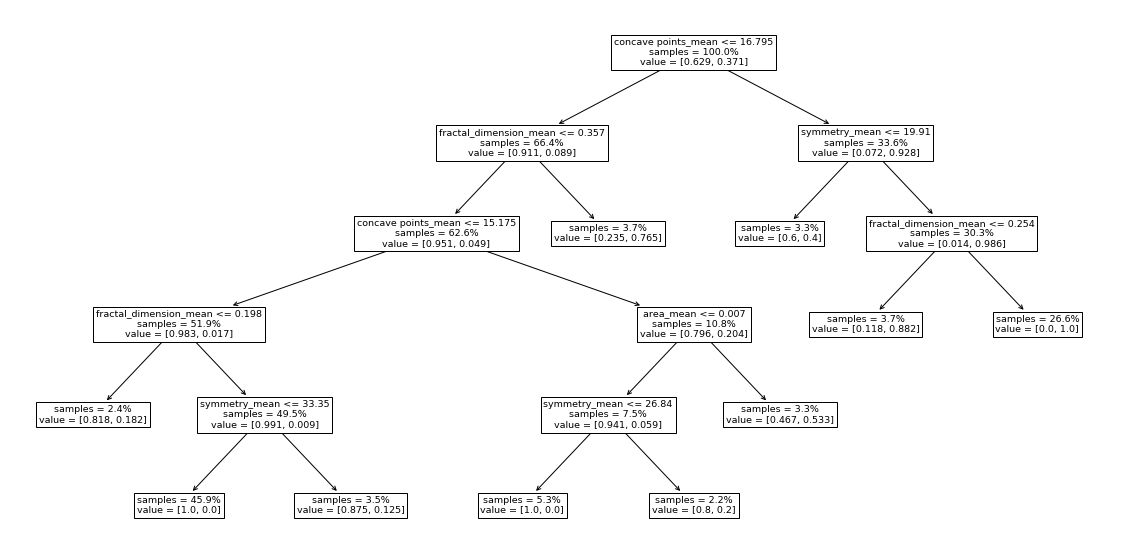

In [14]:
model_DT= grid_DT.best_estimator_
plt.figure(figsize=(20,10)) 
tree.plot_tree(model_DT, feature_names=df_processed.columns[0:-1], impurity=False, proportion=True)

In [15]:
print(metrics.confusion_matrix(y_test, prediction_DT))

[[67  4]
 [ 5 38]]


In [16]:
tree_tn, tree_fn, tree_fp, tree_tp = metrics.confusion_matrix(y_test, prediction_DT).ravel()
recall_DT= tree_tp/(tree_tp + tree_fn)
print(recall_DT)

0.9047619047619048


## Accuracy decreased from 95% to 92%, recall decreased from 93% to 90%
### Idea for more work: look at the change of recall and accuracy with the step-wise removal of features 

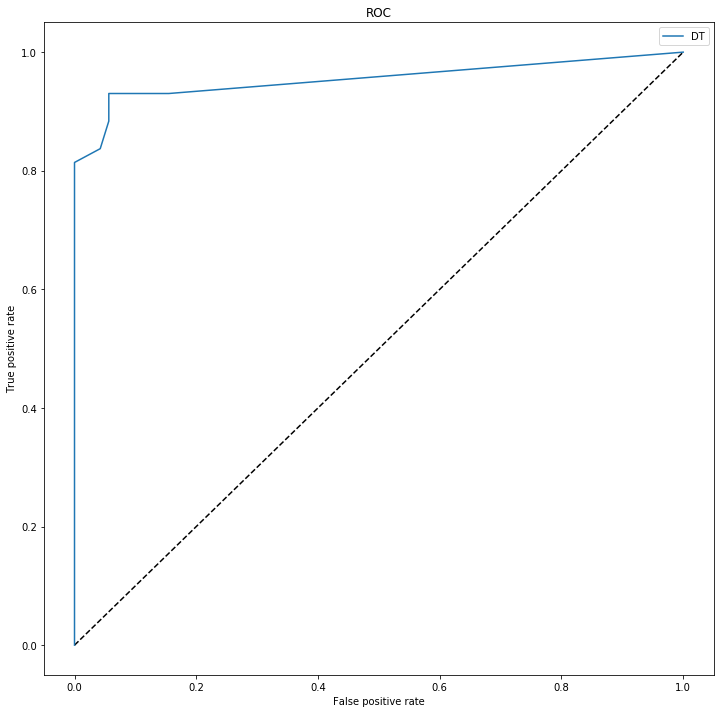

In [17]:
false_pos_rate_DT,true_pos_rate_DT, thresholds_DT = roc_curve(y_test, probability_DT[:, 1])

# Plot the ROC curve
fig = plt.figure(figsize=(12,12))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_pos_rate_DT, true_pos_rate_DT, label='DT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc='best')
plt.show()